# cVAS phase direction finding

In [143]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

plt.rc('font', size=15)

#
# Overlap-add FIR filter, (c) Joachim Thiemann 2016
# https://github.com/jthiem/overlapadd/blob/master/olafilt.py
#
def fftfilt(b, x, zi=None):
    """
    Filter a one-dimensional array with an FIR filter

    Filter a data sequence, `x`, using a FIR filter given in `b`.
    Filtering uses the overlap-add method converting both `x` and `b`
    into frequency domain first.  The FFT size is determined as the
    next higher power of 2 of twice the length of `b`.

    Parameters
    ----------
    b : one-dimensional numpy array
        The impulse response of the filter
    x : one-dimensional numpy array
        Signal to be filtered
    zi : one-dimensional numpy array, optional
        Initial condition of the filter, but in reality just the
        runout of the previous computation.  If `zi` is None or not
        given, then zero initial state is assumed.

    Returns
    -------
    y : array
        The output of the digital filter.
    zf : array, optional
        If `zi` is None, this is not returned, otherwise, `zf` holds the
        final filter delay values.
    """

    L_I = b.shape[0]
    # Find power of 2 larger that 2*L_I (from abarnert on Stackoverflow)
    L_F = 2<<(L_I-1).bit_length()
    L_S = L_F - L_I + 1
    L_sig = x.shape[0]
    offsets = range(0, L_sig, L_S)

    # handle complex or real input
    if np.iscomplexobj(b) or np.iscomplexobj(x):
        fft_func = np.fft.fft
        ifft_func = np.fft.ifft
        res = np.zeros(L_sig+L_F, dtype=np.complex128)
    else:
        fft_func = np.fft.rfft
        ifft_func = np.fft.irfft
        res = np.zeros(L_sig+L_F)

    FDir = fft_func(b, n=L_F)

    # overlap and add
    for n in offsets:
        res[n:n+L_F] += ifft_func(fft_func(x[n:n+L_S], n=L_F)*FDir)

    if zi is not None:
        res[:zi.shape[0]] = res[:zi.shape[0]] + zi
        return res[:L_sig], res[L_sig:]
    else:
        return res[:L_sig]


# cVAS hydrophones
# octahedron (x points from 'centre' towards hydrophone 1)
ro=0.040 # m
dz=np.sqrt(2)
ang=np.array([0,120,240,60,180,300])*np.pi/180
#
ho=np.empty((len(ang),3))
ho[:,:]=np.transpose([np.cos(ang[:]),np.sin(ang[:]),-dz/2+0*ang[:]])
ho[3:,2] += dz
ho *= ro
isel=np.array([[0,1],[0,2],[0,3],[0,4],[0,5],
            [1,2],[1,3],[1,4],[1,5],
            [2,3],[2,4],[2,5],
            [3,4],[3,5],
            [4,5]])

nc=np.shape(isel)[0]

D=ho[isel[:,1],]-ho[isel[:,0],]
L=np.sqrt(np.sum(D**2,1))
print(0.75/L, 'kHz')
DI=np.linalg.pinv(D)

#simulate signal arrival
az=5*np.pi/180
bd=900 # bottom depth m
hd=500 # hydrophone depth m
sd=800 # source depth m
dx=5000 # source distance m
#
r1=np.sqrt(dx**2 + (hd-sd)**2)
r2=np.sqrt(dx**2 + (hd+sd)**2)
dr = r2-r1
dt = dr/1.5     # ms

a1=1
a2=-0.5*r1/r2

el1=np.arctan2(hd-sd,dx)
el2=np.arctan2(hd+sd,dx)

#print(np.array([r1,r2,dr,dt]))
print('Angles: ',np.array([az,el1,el2])*180/np.pi)
print('Time delay: ',dt)

#hydrophone delay simulation
S1=np.array([np.cos(az)*np.cos(el1),np.sin(az)*np.cos(el1), np.sin(el1)])
S2=np.array([np.cos(az)*np.cos(el2),np.sin(az)*np.cos(el2), np.sin(el2)])
DC1=np.sum(ho*S1,1)
DC2=np.sum(ho*S2,1)
DT1=DC1/1.500   # ms
DT2=DC2/1.500   # ms

print(DT1, 'ms')
print(DT2, 'ms')


[10.82531755 10.82531755 10.82531755  7.65465545 10.82531755 10.82531755
 10.82531755 10.82531755  7.65465545  7.65465545 10.82531755 10.82531755
 10.82531755 10.82531755 10.82531755] kHz
Angles:  [ 5.         -3.43363036 14.5742162 ]
Time delay:  104.82975112567874
[ 0.02764684 -0.01012025 -0.01413857  0.01413857 -0.02764684  0.01012025] ms
[ 0.02096554 -0.01565204 -0.01954806  0.01954806 -0.02096554  0.01565204] ms


[ 2.65409695 -0.97154394 -1.35730312  1.35730312 -2.65409695  0.97154394] samples


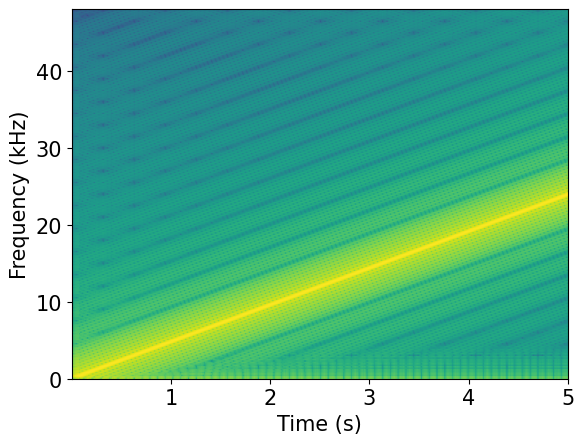

In [144]:

# Simulate LFM
fs=96000    # sampling frequency (Hz)
t2=5        # LFM duration (s)

f1=0        # LFM start frequency (Hz)
f2=24000    # LFM stop frequency (Hz)

# generate time vector
tt=np.arange(0,t2,1/fs)
# generate modulation frequency
om=2*np.pi*(f1+(f2-f1)/2*tt/t2)
#
xx=np.sin(om*tt)
#
print(DT1*fs/1000, 'samples')
#
# prepare some more space than needed for signal
yy=np.zeros(len(tt)+2*96)
nd=np.shape(xx)[0]
ndh=nd//2
#
# for matched filter  (here not used)
rep=np.flipud(xx)/np.sqrt((nd/2*np.sum(xx**2)))
#

yy[96:-96]+=xx
ty=np.arange(len(yy))/fs
#
f,t,S1= sig.spectrogram(yy,fs=fs,nperseg=256,noverlap=128,nfft=512)

plt.imshow(10*np.log10(S1),origin='lower', aspect='auto',extent=(t[0],t[-1],f[0]/1000,f[-1]/1000))
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')
plt.show();


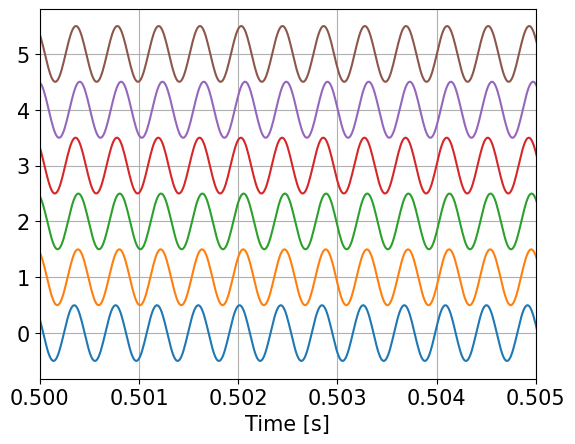

In [145]:
#delay signal according to array geometry
kk=np.arange(-10,10,1);
ss=np.zeros((len(yy),len(DT1)))
for ii in range(len(DT1)):
    ss[:,ii]=fftfilt(np.sinc(kk+DT1[ii]*fs/1000),yy)

plt.plot(ty,0.5*ss+np.ones((ss.shape[0],1))*np.arange(len(DT1)));
plt.grid(True)
plt.xlim(0.5, 0.505)
plt.xlabel('Time [s]')
plt.show()

(0.5, 0.505)

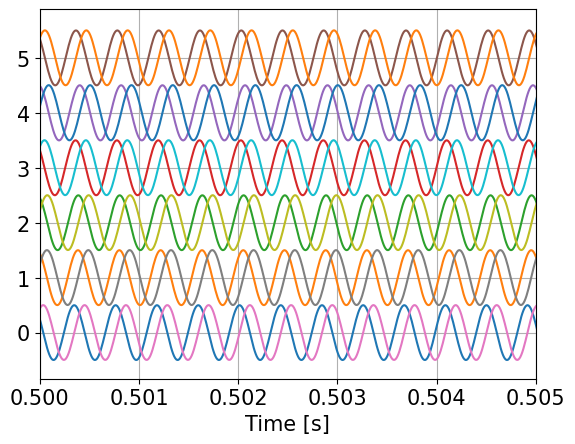

In [146]:
zz=sig.hilbert(ss,axis=0)
plt.plot(ty,0.5*zz.real+np.ones((ss.shape[0],1))*np.arange(len(DT1)));
plt.plot(ty,0.5*zz.imag+np.ones((ss.shape[0],1))*np.arange(len(DT1)));
#plt.plot(tt,0.9*np.abs(zz)+np.ones((ss.shape[0],1))*np.arange(len(DT1)));
plt.grid(True)
plt.xlabel('Time [s]')
plt.xlim(0.5, 0.505)

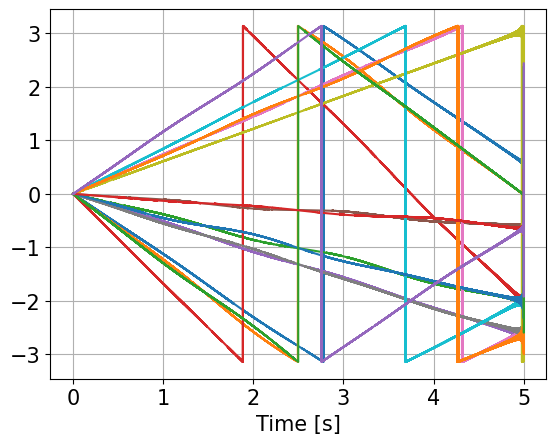

In [147]:
ns=np.shape(isel)[0]
DPhi=np.zeros((ss.shape[0],ns))
for ii in range(ns):
    DPhi[:,ii]= np.log(zz[:,isel[ii,1]]/zz[:,isel[ii,0]]).imag

uu=DPhi.copy()
plt.plot(ty,uu)
plt.grid(True)
plt.xlabel('Time [s]')
plt.show()

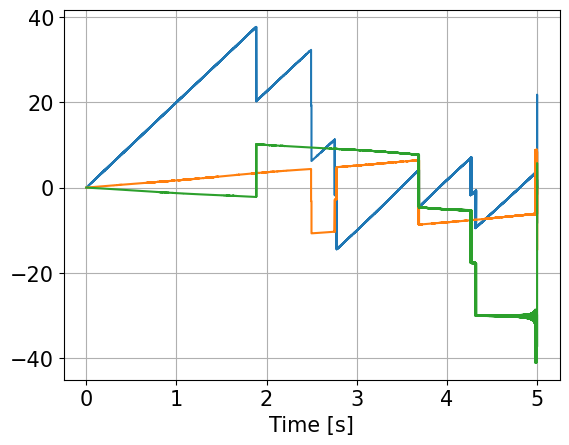

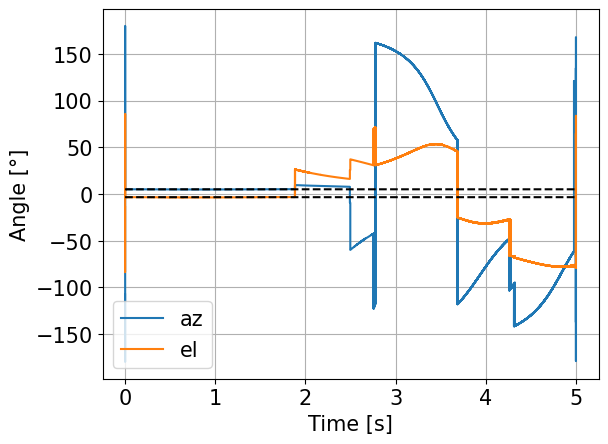

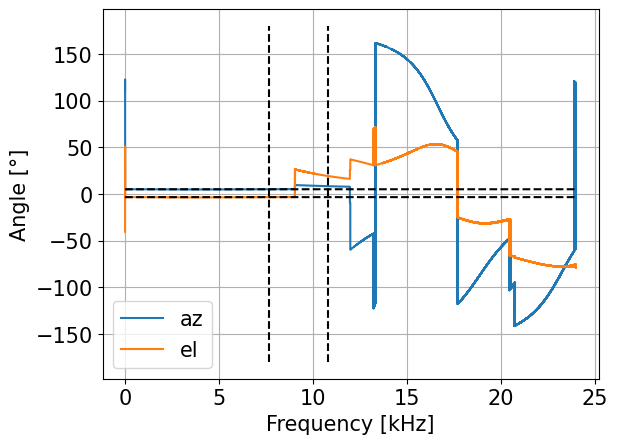

In [148]:
vv=uu@DI.T

plt.plot(ty,vv)
plt.grid(True)
plt.xlabel('Time [s]')
plt.show()

azx=180/np.pi*np.arctan2(vv[:,1],vv[:,0])
elx=180/np.pi*np.arctan2(vv[:,2],np.sqrt(vv[:,0]**2+vv[:,1]**2))

plt.plot(ty,azx,label='az')
plt.plot(ty,elx,label='el')
plt.plot(ty,180/np.pi*az+0*ty,'k--')
plt.plot(ty,180/np.pi*el1+0*ty,'k--')
plt.grid(True)
#plt.ylim(-10,10)
plt.xlabel('Time [s]')
plt.ylabel('Angle [°]')
plt.legend()
plt.show()

ifr=96+np.arange(len(om),dtype='int')
fr=om/(np.pi)/1000

plt.plot(fr,azx[ifr], label='az')
plt.plot(fr,elx[ifr], label='el')
plt.plot(fr,180/np.pi*az+0*fr,'k--')
plt.plot(fr,180/np.pi*el1+0*fr,'k--')
plt.vlines(np.min(0.75/L),-180,180,colors='k',linestyles='--')
plt.vlines(np.max(0.75/L),-180,180,colors='k',linestyles='--')
plt.grid(True)
#plt.ylim(-20,20)
plt.xlabel('Frequency [kHz]')
plt.ylabel('Angle [°]')
plt.legend()
plt.show()

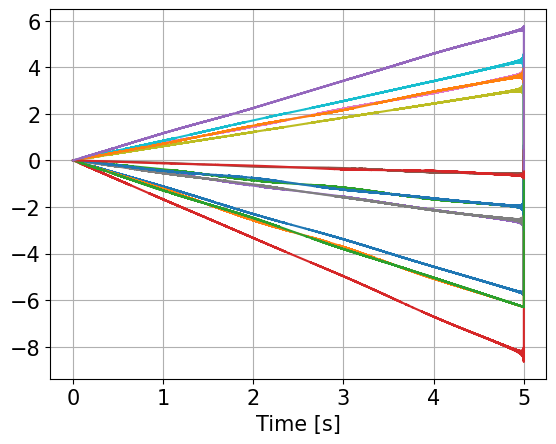

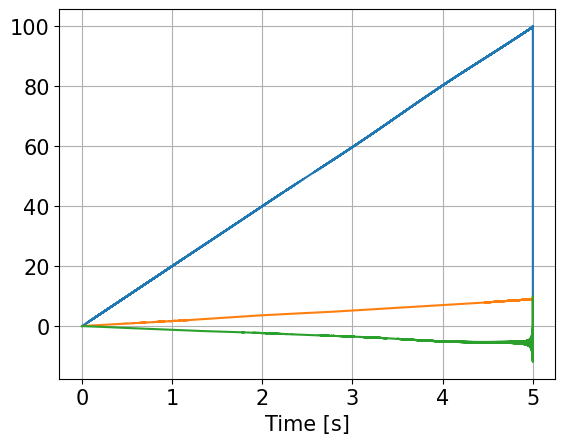

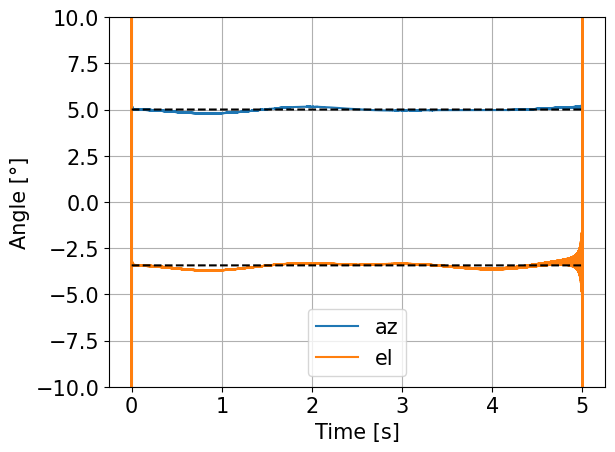

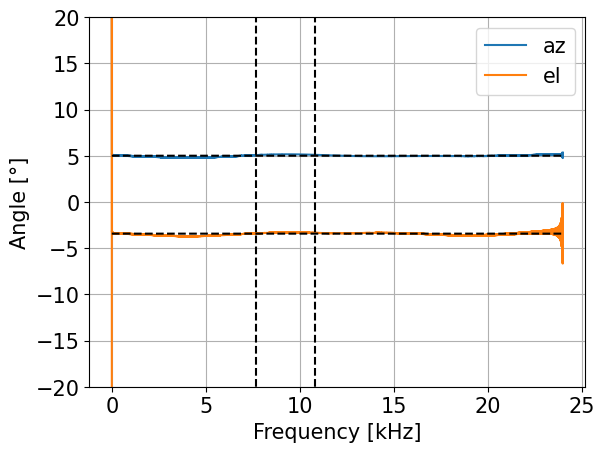

In [149]:
#
# unwrap phase before arithmetic
uu=np.unwrap(DPhi,axis=0)

plt.plot(ty,uu)
plt.grid(True)
plt.xlabel('Time [s]')
plt.show()

vv=uu@DI.T
plt.plot(ty,vv)
plt.grid(True)
plt.xlabel('Time [s]')
plt.show()

azx=180/np.pi*np.arctan2(vv[:,1],vv[:,0])
elx=180/np.pi*np.arctan2(vv[:,2],np.sqrt(vv[:,0]**2+vv[:,1]**2))

plt.plot(ty,azx,label='az')
plt.plot(ty,elx,label='el')
plt.plot(ty,180/np.pi*az+0*ty,'k--')
plt.plot(ty,180/np.pi*el1+0*ty,'k--')
plt.grid(True)
plt.ylim(-10,10)
plt.xlabel('Time [s]')
plt.ylabel('Angle [°]')
plt.legend()
plt.show()

ifr=96+np.arange(len(om),dtype='int')
fr=om/(np.pi)/1000

plt.plot(fr,azx[ifr], label='az')
plt.plot(fr,elx[ifr], label='el')
plt.plot(fr,180/np.pi*az+0*fr,'k--')
plt.plot(fr,180/np.pi*el1+0*fr,'k--')
plt.vlines(np.min(0.75/L),-180,180,colors='k',linestyles='--')
plt.vlines(np.max(0.75/L),-180,180,colors='k',linestyles='--')
plt.grid(True)
plt.ylim(-20,20)
plt.xlabel('Frequency [kHz]')
plt.ylabel('Angle [°]')
plt.legend()
plt.show()

0.7066132750779587 0.01000425946649532 36.97993690664079


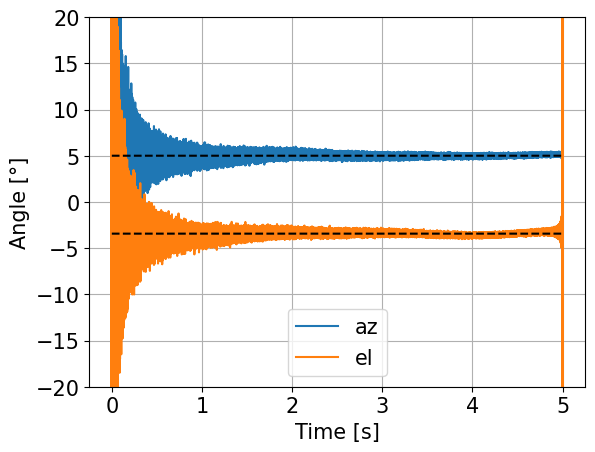

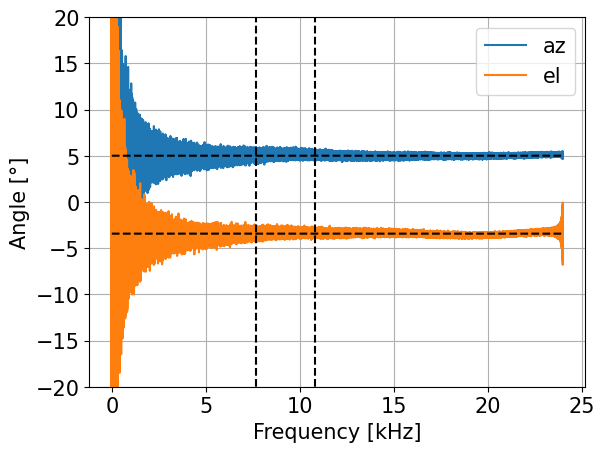

In [150]:
# normal distributed noise
nn=np.random.normal(scale=0.01, size=ss.shape)
zz=sig.hilbert(ss+nn,axis=0)
print(ss.std(),nn.std(),20*np.log10(ss.std()/nn.std()) )

for ii in range(ns):
    DPhi[:,ii]= np.log(zz[:,isel[ii,1]]/zz[:,isel[ii,0]]).imag

#uu=DPhi.copy()
uu=np.unwrap(DPhi,axis=0)
vv=uu@DI.T

azx=180/np.pi*np.arctan2(vv[:,1],vv[:,0])
elx=180/np.pi*np.arctan2(vv[:,2],np.sqrt(vv[:,0]**2+vv[:,1]**2))

plt.plot(ty,azx, label='az')
plt.plot(ty,elx, label='el')
plt.plot(ty,180/np.pi*az+0*ty,'k--')
plt.plot(ty,180/np.pi*el1+0*ty,'k--')
plt.grid(True)
plt.ylim(-20,20)
plt.xlabel('Time [s]')
plt.ylabel('Angle [°]')
plt.legend()
plt.show()

ifr=96+np.arange(len(om),dtype='int')
fr=om/(np.pi)/1000

plt.plot(fr,azx[ifr], label='az')
plt.plot(fr,elx[ifr], label='el')
plt.plot(fr,180/np.pi*az+0*fr,'k--')
plt.plot(fr,180/np.pi*el1+0*fr,'k--')
plt.vlines(np.min(0.75/L),-180,180,colors='k',linestyles='--')
plt.vlines(np.max(0.75/L),-180,180,colors='k',linestyles='--')
plt.grid(True)
plt.ylim(-20,20)
plt.xlabel('Frequency [kHz]')
plt.ylabel('Angle [°]')
plt.legend()
plt.show()